In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde, ks_2samp, zscore, stats
import matplotlib.path as mpath
import scipy.stats as stats
import sys
import platform
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.gridspec import GridSpec

def load_clinical_manifest(directory):
    """
    Load the clinical manifest from a specified directory.

    Inputs:
    - directory (str): The directory path where the file is located.

    Outputs:
    - clinical_manifest (DataFrame): A DataFrame containing the clinical manifest data.
    """
    filepath = os.path.join(directory, 'clinical_gdc_manifest.txt')
    clinical_manifest = pd.read_csv(filepath, sep='\t')
    print('Clinical manifest shape:', clinical_manifest.shape)
    return clinical_manifest


def analyze_filenames(manifest_df, directory_path):
    """
    Analyze the uniqueness and overlap of filenames between a manifest and a directory.

    Inputs:
    - manifest_df (DataFrame): Manifest containing filenames.
    - directory_path (str): Directory path containing files to compare.

    Outputs:
    - dict: Summary of percentages including unique filenames, overlap, and non-overlap.
    """
    total_filenames = len(manifest_df['filename'])
    unique_filenames = len(manifest_df['filename'].unique())
    percent_unique = (unique_filenames / total_filenames) * 100

    directory_files = set(os.listdir(directory_path))
    manifest_files = set(manifest_df['filename'])

    overlap_files = manifest_files.intersection(directory_files)
    percent_overlap = (len(overlap_files) / total_filenames) * 100
    non_overlap_files = manifest_files.difference(directory_files)
    percent_non_overlap = (len(non_overlap_files) / total_filenames) * 100

    return {
        "percent_unique_filenames_in_manifest": percent_unique,
        "percent_overlap_with_directory": percent_overlap,
        "percent_non_overlap_with_directory": percent_non_overlap
    }

def load_dataframes(exps_filename, key_filename):
    """
    Load gene expression and key DataFrames from files.

    Inputs:
    - exps_filename (str): Path to gene expression file.
    - key_filename (str): Path to gene key file.

    Outputs:
    - gene_exps (DataFrame): Loaded gene expression data.
    - gene_key (DataFrame): Loaded gene key data.
    """
    gene_exps = pd.read_csv(exps_filename, index_col=0)
    gene_key = pd.read_csv(key_filename, index_col=0)
    return gene_exps, gene_key

def normalize_gene_expressions(df):
    """
    Normalize gene expressions using Z-score normalization.

    Inputs:
    - df (DataFrame): DataFrame with gene expression data.

    Outputs:
    - normalized_df (DataFrame): Normalized DataFrame with the same shape as input.
    """
    return df.apply(zscore, axis=1)

def clean_and_classify_dataframe(df, classify_by):
    """
    Clean and classify a clinical manifest DataFrame by removing unnecessary columns, marking healthy samples,
    and adding a classification column based on either cancer type or cancer stage.

    Inputs:
    - df (DataFrame): The clinical manifest DataFrame to be cleaned and classified.
    - classify_by (str): The classification criterion ('cancer_type' or 'cancer_stage').

    Outputs:
    - df_copy (DataFrame): A cleaned and classified DataFrame.

    Function details:
    - Filters and modifies specific columns to mark healthy samples as 'Healthy'.
    - Adds a new column ('cancer_type' or 'cancer_stage') based on the classify_by parameter.
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Define the sample types considered healthy
    healthy_sample_types = ['Blood Derived Normal', 'Bone Marrow Normal', 'Control Analyte', 'Solid Tissue Normal']

    # Define columns that may be updated to 'Healthy' based on conditions
    health_info_columns = [
        "ajcc_pathologic_stage", "tumor_grade", "ajcc_pathologic_t", "ajcc_pathologic_m",
        "ajcc_pathologic_n", "figo_stage", "wilms_tumor_histologic_subtype", 'diagnosis_iss_stage',
        'diagnosis_ann_arbor_pathologic_stage', 'diagnosis_ajcc_pathologic_stage'
    ]

    # Iterate over each column in the DataFrame to clean or update based on conditions
    for column in df_copy.columns:
        unique_values = df_copy[column].dropna().unique()

        # Drop columns that are entirely NaN or contain only uninformative values like 'Not Reported'
        if len(unique_values) == 0 or (len(unique_values) == 1 and unique_values[0] in ['Not Reported', 'not reported', 'None']):
            df_copy.drop(column, axis=1, inplace=True)
        else:
            # Update specific columns to mark healthy samples as 'Healthy'
            if column in health_info_columns:
                condition = (
                    df_copy['sample_type'].isin(healthy_sample_types) & 
                    df_copy[column].notna() & 
                    df_copy[column].astype(str).str.strip().ne('')  # Ensure non-empty string values
                )
                df_copy.loc[condition, column] = 'Healthy'

    # Add a new column for classification based on the classify_by parameter
    if classify_by == 'cancer_type':
        # Add the 'cancer_type' column if the relevant diagnosis column exists
        if 'diagnosis_primary_diagnosis' in df_copy.columns:
            df_copy['cancer_type'] = df_copy['diagnosis_primary_diagnosis'].apply(classify_cancer_type)
            # Update 'cancer_type' to 'Healthy' for healthy sample types
            df_copy.loc[df_copy['sample_type'].isin(healthy_sample_types), 'cancer_type'] = 'Healthy'
        else:
            # If the diagnosis column is missing, default to 'Unknown'
            df_copy['cancer_type'] = 'Unknown'
    elif classify_by == 'cancer_stage':
        # Add the 'cancer_stage' column if the relevant stage column exists
        if 'diagnosis_ajcc_pathologic_stage' in df_copy.columns:
            df_copy['cancer_stage'] = df_copy['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)
        else:
            # If the stage column is missing, default to 'Unknown'
            df_copy['cancer_stage'] = 'Unknown'
    
    # Print the shape of the cleaned DataFrame for verification
    print('Cleaned clinical manifest shape:', df_copy.shape)
    
    # Return the cleaned and classified DataFrame
    return df_copy
    
def create_cancer_type_column(clinical_manifest):
    """
    Function use:
    Create and add a 'cancer_type' column to the clinical manifest DataFrame based on primary diagnoses.

    Inputs:
    - clinical_manifest (DataFrame): The clinical manifest DataFrame.

    Outputs:
    - new_clinical_manifest (DataFrame): Updated DataFrame with the 'cancer_type' column.

    Function details:
    - Determines cancer type using the 'diagnosis_primary_diagnosis' column.
    - Marks healthy samples as 'Healthy' based on sample types.
    """
    # Create a copy of the clinical manifest to avoid modifying the original DataFrame
    new_clinical_manifest = clinical_manifest.copy()

    # Add 'cancer_type' column using the classify_cancer_type function
    new_clinical_manifest['cancer_type'] = new_clinical_manifest['diagnosis_primary_diagnosis'].apply(classify_cancer_type)

    # Update 'cancer_type' to 'Healthy' for samples with specific healthy sample types
    healthy_sample_types = ['Blood Derived Normal', 'Bone Marrow Normal', 'Control Analyte', 'Solid Tissue Normal']
    new_clinical_manifest.loc[new_clinical_manifest['sample_type'].isin(healthy_sample_types), 'cancer_type'] = 'Healthy'
    
    # Return the updated DataFrame
    return new_clinical_manifest

def classify_cancer_type(row):
    """
    Classify cancer types into predefined categories based on primary diagnosis (blood and bone marrow).

    Inputs:
    - row (str): The diagnosis string to classify.

    Outputs:
    - str: The cancer type classification ('Leukemia', 'Lymphoma', 'Myeloma', 'Other_Cancer', or 'Unknown').

    Function details:
    - Matches diagnoses to predefined categories for Leukemia, Lymphoma, Myeloma, and Other_Cancer.
    - Default classification is 'Unknown' if the diagnosis does not match any predefined type.
    """
    leukemia_types = [
        "Acute myeloid leukemia, NOS", "Common precursor B ALL", "Acute lymphocytic leukemia",
        "Acute myeloid leukemia with mutated NPM1", "Acute lymphoblastic leukemia, NOS",
        "Acute myeloid leukemia with myelodysplasia-related changes", "Leukemia, NOS",
        "Acute myeloid leukemia, CBF-beta/MYH11", "Acute myeloid leukemia with mutated CEBPA",
        "Acute myelomonocytic leukemia", "Acute promyelocytic leukaemia, PML-RAR-alpha",
        "Atypical chronic myeloid leukemia, BCR/ABL negative", "Acute monoblastic and monocytic leukemia",
        "Chronic neutrophilic leukemia", "Acute myeloid leukemia with t(8;21)(q22;q22); RUNX1-RUNX1T1",
        "Acute myeloid leukemia with t(9;11)(p22;q23); MLLT3-MLL",
        "Acute myeloid leukemia with inv(3)(q21q26.2) or t(3;3)(q21;q26.2); RPN1-EVI1",
        "Acute leukemia, NOS", "Acute myeloid leukemia, minimal differentiation",
        "Precursor B-cell lymphoblastic leukemia", "Precursor cell lymphoblastic leukemia, not phenotyped",
        "Precursor cell lymphoblastic leukemia, NOS", "Chronic myelomonocytic leukemia, NOS",
        "Acute myeloid leukemia with t(6;9)(p23;q34); DEK-NUP214", "Mixed phenotype acute leukemia, T/myeloid, NOS",
        "Acute erythroid leukaemia", "Refractory anemia with excess blasts", "Subacute lymphoid leukemia",
        "Essential thrombocythemia", "Mixed phenotype acute leukemia, B/myeloid, NOS",
        "Acute megakaryoblastic leukaemia", "Undifferentiated leukaemia", "Lymphoid leukemia, NOS",
        "Myeloid leukemia associated with Down Syndrome", "Chronic lymphocytic leukemia"
    ]
    
    lymphoma_types = [
        "Burkitt lymphoma, NOS (Includes all variants)", "Diffuse large B-cell lymphoma, NOS",
        "Burkitt-like lymphoma", "B cell lymphoma, NOS", "EBV positive diffuse large B-cell lymphoma of the elderly",
        "Primary diffuse large B-cell lymphoma of the CNS",
        "B-cell lymphoma, unclassifiable, with features intermediate between diffuse large B-cell lymphoma and Burkitt lymphoma"
    ]
    
    myeloma_types = [
        "Multiple myeloma", "Plasma cell myeloma"
    ]
    
    other_types = [
        "Therapy related myeloid neoplasm", "Myelodysplastic/myeloproliferative neoplasm, unclassifiable",
        "Myloproliferative neoplasm, unclassifiable", "Myeloid sarcoma", "Myelodysplastic syndrome, unclassifiable",
        "Refractory cytopenia with multilineage dysplasia", "Neuroblastoma, NOS", "Osteosarcoma, NOS",
        "Neoplasm, uncertain whether benign or malignant", "Blastic plasmacytoid dendritic cell neoplasm",
        "Tumor, NOS"
    ]
    
    unknown_types = [
        "Not Reported", "Unknown"
    ]
    
    # Match the diagnosis to predefined categories
    if row in leukemia_types:
        return 'Leukemia'
    elif row in lymphoma_types:
        return 'Lymphoma'
    elif row in myeloma_types:
        return 'Myeloma'
    elif row in other_types:
        return 'Other_Cancer'
    elif row in unknown_types:
        return 'Unknown'
    else:
        # Default to 'Other' for unmatched diagnoses
        return 'Other'

def combine_stages(stage):
    """
    Combine detailed cancer stages into broader categories for standardization.

    Inputs:
    - stage (str): Detailed stage string.

    Outputs:
    - str: Combined stage string or 'Unknown' for missing/unknown data.

    Function details:
    - Maps detailed cancer stages (e.g., 'Stage IA') to broader categories (e.g., 'Stage I').
    - Returns 'Unknown' for missing or uninformative stage data.
    """
    # Define mapping from detailed to broader stages
    stage_mapping = {
        'Stage IA': 'Stage I', 'Stage IA1': 'Stage I', 'Stage IA2': 'Stage I', 'Stage IA3': 'Stage I', 'Stage IB': 'Stage I', 'Stage IC': 'Stage I',
        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 'Stage IIC': 'Stage II', 'Stage IIIC1': 'Stage II', 'Stage IIIC2': 'Stage II',
        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III', 'Stage IIIC': 'Stage III',
        'Stage IVA': 'Stage IV', 'Stage IVB': 'Stage IV', 'Stage IVC': 'Stage IV',
        'Stage X': 'Stage X'
    }
    
    # Handle missing or unknown stage values
    if pd.isna(stage) or stage in ["Unknown", "Not Reported"]:
        return "Unknown"
    
    # Return the mapped broader stage or the original stage if not in the mapping
    return stage_mapping.get(stage, stage)

def add_multiple_gene_expressions_to_clinical(gene_exps, clinical_manifest, gene_key, gene_names):
    """
    Add multiple gene expressions to the clinical manifest DataFrame.

    Parameters:
    - gene_exps: DataFrame containing gene expressions.
    - clinical_manifest: DataFrame containing clinical manifest data.
    - gene_key: DataFrame containing gene IDs and names.
    - gene_names: List of gene names to be added.

    Returns:
    - Updated clinical manifest DataFrame with gene expressions.
    """
    for gene_name in gene_names:
        # Find the ENSG code for the given gene_name
        gene_id = gene_key.loc[gene_key['gene_name'] == gene_name, 'gene_id'].iloc[0]
        
        # Extract the relevant gene expression column
        gene_exps_reset = gene_exps.reset_index()
        gene_expression_series = gene_exps_reset.set_index('filename')[gene_id]
        
        # Add the gene expression data to the clinical manifest
        clinical_manifest[gene_name] = clinical_manifest['filename'].apply(lambda x: gene_expression_series.get(x, None))
    
    # Reordering columns to have gene names as the first columns
    cols = gene_names + [col for col in clinical_manifest if col not in gene_names]
    updated_clinical_manifest = clinical_manifest[cols]
    
    return updated_clinical_manifest

def add_gene_expression_to_clinical(gene_exps, clinical_manifest, gene_key, gene_name):
    """
    Add the expression data for a specific gene to the clinical manifest.

    Inputs:
    - gene_exps (DataFrame): Gene expression data.
    - clinical_manifest (DataFrame): Clinical manifest DataFrame.
    - gene_key (DataFrame): Mapping of gene names to their IDs.
    - gene_name (str): Name of the gene to add.

    Outputs:
    - clinical_manifest (DataFrame): Updated clinical manifest with the gene's expression data.
    """
    gene_id = gene_key.loc[gene_key['gene_name'] == gene_name, 'gene_id'].iloc[0]
    gene_expression_series = gene_exps.reset_index().set_index('filename')[gene_id]
    clinical_manifest['gene_expression'] = clinical_manifest['filename'].map(gene_expression_series)
    clinical_manifest.rename(columns={'gene_expression': gene_name}, inplace=True)
    return clinical_manifest

def clean_and_classify_dataframe(df, classify_by):
    """
    Clean a clinical manifest DataFrame by removing irrelevant columns and classifying rows
    based on cancer type or stage.

    Inputs:
    - df (DataFrame): Clinical manifest to be cleaned and classified.
    - classify_by (str): Classification criteria, either 'cancer_type' or 'cancer_stage'.

    Outputs:
    - df_copy (DataFrame): Cleaned and classified DataFrame.

    Function details:
    - Removes columns that are completely missing or have only uninformative values ('Not Reported', 'None').
    - Updates specific columns with 'Healthy' if the sample type indicates a healthy sample.
    - Adds a 'cancer_type' or 'cancer_stage' column based on the classification criteria.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Define healthy sample types for classification
    healthy_sample_types = ['Blood Derived Normal', 'Bone Marrow Normal', 'Control Analyte', 'Solid Tissue Normal']

    # List of columns that might indicate health status
    health_info_columns = [
        "ajcc_pathologic_stage", "tumor_grade", "ajcc_pathologic_t", "ajcc_pathologic_m",
        "ajcc_pathologic_n", "figo_stage", "wilms_tumor_histologic_subtype", 'diagnosis_iss_stage',
        'diagnosis_ann_arbor_pathologic_stage', 'diagnosis_ajcc_pathologic_stage'
    ]

    # Remove irrelevant columns and update health information for relevant columns
    for column in df_copy.columns:
        unique_values = df_copy[column].dropna().unique()

        # Drop columns that are completely missing or contain only uninformative values
        if len(unique_values) == 0 or (len(unique_values) == 1 and unique_values[0] in ['Not Reported', 'not reported', 'None']):
            df_copy.drop(column, axis=1, inplace=True)
        else:
            # Update health information for specific columns
            if column in health_info_columns:
                condition = (
                    df_copy['sample_type'].isin(healthy_sample_types) & 
                    df_copy[column].notna() & 
                    df_copy[column].astype(str).str.strip().ne('')
                )
                df_copy.loc[condition, column] = 'Healthy'

    # Add classification column based on the selected criterion
    if classify_by == 'cancer_type':
        if 'diagnosis_primary_diagnosis' in df_copy.columns:
            df_copy['cancer_type'] = df_copy['diagnosis_primary_diagnosis'].apply(classify_cancer_type)
            df_copy.loc[df_copy['sample_type'].isin(healthy_sample_types), 'cancer_type'] = 'Healthy'
        else:
            df_copy['cancer_type'] = 'Unknown'
    elif classify_by == 'cancer_stage':
        if 'diagnosis_ajcc_pathologic_stage' in df_copy.columns:
            df_copy['cancer_stage'] = df_copy['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)
        else:
            df_copy['cancer_stage'] = 'Unknown'

    # Log the shape of the cleaned DataFrame
    print('Cleaned clinical manifest shape:', df_copy.shape)

    # Return the cleaned and classified DataFrame
    return df_copy

def clean_dataframe(df):
    """
    Clean a clinical manifest DataFrame by removing irrelevant columns and standardizing health information.

    Inputs:
    - df (DataFrame): Clinical manifest to be cleaned.

    Outputs:
    - df_copy (DataFrame): Cleaned DataFrame.

    Function details:
    - Removes columns that are completely missing or have only uninformative values ('Not Reported', 'None').
    - Updates specific columns with 'healthy tissue' if the sample type indicates a healthy sample.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Define healthy sample types for classification
    healthy_sample_types = ['Blood Derived Normal', 'Bone Marrow Normal', 'Control Analyte', 'Solid Tissue Normal']

    # List of columns that might indicate health status
    health_info_columns = [
        "ajcc_pathologic_stage", "tumor_grade", "ajcc_pathologic_t", "ajcc_pathologic_m",
        "ajcc_pathologic_n", "figo_stage", "wilms_tumor_histologic_subtype", 'diagnosis_iss_stage',
        'diagnosis_ann_arbor_pathologic_stage', 'diagnosis_ajcc_pathologic_stage'
    ]

    # Remove irrelevant columns and update health information for relevant columns
    for column in df_copy.columns:
        unique_values = df_copy[column].dropna().unique()

        # Drop columns that are completely missing or contain only uninformative values
        if len(unique_values) == 0 or (len(unique_values) == 1 and unique_values[0] in ['Not Reported', 'not reported', 'None']):
            df_copy.drop(column, axis=1, inplace=True)
        else:
            # Update health information for specific columns
            if column in health_info_columns:
                condition = (
                    df_copy['sample_type'].isin(healthy_sample_types) & 
                    df_copy[column].notna() & 
                    df_copy[column].astype(str).str.strip().ne('')
                )
                df_copy.loc[condition, column] = 'healthy tissue'

    # Log the shape of the cleaned DataFrame
    print('Cleaned clinical manifest shape:', df_copy.shape)

    # Return the cleaned DataFrame
    return df_copy

def plot_ogt_vs_oga_with_heatmap(clinical_manifest, group_column, see_through=0.05, sensitivity_threshold=None, 
                                 remove_outliers=False, plot_verification_points=False, zoom_limits=None, lvls=30, title=""):
    """
    Calculate KDE regulation scores and Visualize OGT vs OGA expression levels with a Regulation Score-based heatmap

    Inputs:
    - clinical_manifest (DataFrame): Input DataFrame containing OGT and OGA expression data.
    - group_column (str): Column used to classify samples into healthy and cancer groups.
    - see_through (float): Transparency level for scatterplot points.
    - sensitivity_threshold (float): Threshold value for KDE sensitivity. If None, it is automatically calculated.
    - remove_outliers (bool): Whether to filter out outliers based on the IQR.
    - plot_verification_points (bool): Whether to overlay verification points on the plot.
    - zoom_limits (list): Axis limits for zooming into specific areas of the plot. Format: [y_limit, x_limit].
    - lvls (int): Number of contour levels for the heatmap (lower for smaller sample sizes).
    - title (str): Title of the plot.

    Outputs:
    - df (DataFrame): Updated DataFrame with an added column 'O-GlcNAcylation dysregulation' 
      containing dysregulation scores for each sample.
    - threshold for 

    Function details:
    - Filters the input DataFrame to include only samples classified as healthy or cancer.
    - Creates a KDE-based heatmap to visualize density of OGT and OGA expression for healthy samples.
    - Calculates dysregulation scores for all samples based on KDE thresholds.
    - Plots scatter plots, heatmap, and topographical contour lines for the data.
    - Provides average dysregulation scores for healthy and cancer groups.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df = clinical_manifest.copy()
    ogt_column = 'OGT'
    oga_column = 'OGA'

    # Define health status labels
    healthy_labels = ['healthy tissue', 'Healthy']
    unhealthy_labels = ['Leukemia', 'Myeloma', 'Lymphoma', 'Other_Cancer']
    stage_labels = ['Stage I', 'Stage II', 'Stage III', 'Stage IV', 'Stage X']

    # Helper function to check if a sample is relevant
    def is_relevant_sample(label):
        if isinstance(label, str):
            if label in healthy_labels or label in unhealthy_labels:
                return True
            for stage in stage_labels:
                if label.startswith(stage):
                    return True
        return False

    # Filter the DataFrame to retain only relevant samples
    df = df[df[group_column].apply(is_relevant_sample)]

    # Add a column to distinguish between healthy and cancer groups
    df['Health_Status'] = df[group_column].apply(lambda x: 'Healthy' if x in healthy_labels else 'Cancer')

    # Optionally remove outliers based on IQR
    if remove_outliers:
        Q1_oga = df[oga_column].quantile(0.25)
        Q3_oga = df[oga_column].quantile(0.75)
        IQR_oga = Q3_oga - Q1_oga
        lower_bound_oga = Q1_oga - 1.5 * IQR_oga
        upper_bound_oga = Q3_oga + 1.5 * IQR_oga

        Q1_ogt = df[ogt_column].quantile(0.25)
        Q3_ogt = df[ogt_column].quantile(0.75)
        IQR_ogt = Q3_ogt - Q1_ogt
        lower_bound_ogt = Q1_ogt - 1.5 * IQR_ogt
        upper_bound_ogt = Q3_ogt + 1.5 * IQR_ogt

        df = df[(df[oga_column] >= lower_bound_oga) & (df[oga_column] <= upper_bound_oga) &
                (df[ogt_column] >= lower_bound_ogt) & (df[ogt_column] <= upper_bound_ogt)]

    # Automatically calculate sensitivity threshold if not provided
    if sensitivity_threshold is None:
        xy_healthy = np.vstack([df[df['Health_Status'] == 'Healthy'][oga_column], 
                                df[df['Health_Status'] == 'Healthy'][ogt_column]])
        z_healthy = gaussian_kde(xy_healthy)(xy_healthy)
        
        x = np.linspace(df[oga_column].min(), df[oga_column].max(), 2000)
        y = np.linspace(df[ogt_column].min(), df[ogt_column].max(), 2000)
        xgrid, ygrid = np.meshgrid(x, y)
        xygrid = np.vstack([xgrid.ravel(), ygrid.ravel()])
        zgrid_healthy = gaussian_kde(xy_healthy)(xygrid).reshape(xgrid.shape)
        sensitivity_threshold = find_sensitivity_threshold(zgrid_healthy, df, oga_column, ogt_column, xgrid, ygrid)
    
    # Ensure data availability for plotting
    if not df.empty:
        plt.figure(figsize=(10, 6))

        # KDE calculation and heatmap preparation
        xy_healthy = np.vstack([df[df['Health_Status'] == 'Healthy'][oga_column], 
                                df[df['Health_Status'] == 'Healthy'][ogt_column]])
        z_healthy = gaussian_kde(xy_healthy)(xy_healthy)
        
        x = np.linspace(df[oga_column].min(), df[oga_column].max(), 2000)
        y = np.linspace(df[ogt_column].min(), df[ogt_column].max(), 2000)
        xgrid, ygrid = np.meshgrid(x, y)
        xygrid = np.vstack([xgrid.ravel(), ygrid.ravel()])
        zgrid_healthy = gaussian_kde(xy_healthy)(xygrid).reshape(xgrid.shape)
        
        zgrid_healthy_normalized = (zgrid_healthy - zgrid_healthy.min()) / (sensitivity_threshold - zgrid_healthy.min()) * 0.5
        zgrid_healthy_normalized[zgrid_healthy_normalized > 0.5] = 0.5

        zgrid_values = np.zeros_like(zgrid_healthy)
        zgrid_values[zgrid_healthy <= sensitivity_threshold] = zgrid_healthy_normalized[zgrid_healthy <= sensitivity_threshold]
        zgrid_values[zgrid_healthy > sensitivity_threshold] = 0.5 + ((zgrid_healthy[zgrid_healthy > sensitivity_threshold] - sensitivity_threshold) /
                                                                   (zgrid_healthy.max() - sensitivity_threshold)) * 0.5

        points = df[[oga_column, ogt_column]].values
        dysreg_scores = np.array([zgrid_values[np.abs(ygrid[:, 0] - y).argmin(), np.abs(xgrid[0, :] - x).argmin()] for x, y in points])
        df['O-GlcNAcylation dysregulation'] = dysreg_scores

        # # DEBUGGING CODE
        # print(f"sensitivity_threshold: {sensitivity_threshold}")
        # print(f"Normalized Grid Min: {zgrid_healthy_normalized.min()}, Max: {zgrid_healthy_normalized.max()}")
        # print(f"Dysregulation Scores (Sample): {dysreg_scores[:10]}")


        # Scatter plot and heatmap visualization
        sns.scatterplot(x=oga_column, y=ogt_column, data=df[df['Health_Status'] == 'Cancer'], color='red', alpha=see_through, label='Cancer')
        sns.scatterplot(x=oga_column, y=ogt_column, data=df[df['Health_Status'] == 'Healthy'], color='blue', alpha=see_through, label='Healthy')
        
        plt.contourf(xgrid, ygrid, zgrid_healthy_normalized, levels=20, cmap='Blues', alpha=0.5)
        plt.contour(xgrid, ygrid, zgrid_healthy, levels=[sensitivity_threshold], colors='black', linestyles='dashed')
        plt.contourf(xgrid, ygrid, zgrid_values, levels=lvls, cmap='viridis', alpha=0.5)
        

        # Zoom and title settings
        if zoom_limits is not None:
            plt.xlim([0, zoom_limits[1]])
            plt.ylim([0, zoom_limits[0]])

        plt.title(f"{title}", fontsize=20)
        plt.xlabel(oga_column)
        plt.ylabel(ogt_column)
        plt.legend(title='Health Status', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.colorbar(label='KDE Regulation Score', shrink=0.60)

        avg_dysreg_healthy = dysreg_scores[df['Health_Status'] == 'Healthy'].mean()
        avg_dysreg_cancer = dysreg_scores[df['Health_Status'] == 'Cancer'].mean()
        plt.text(0.70, 0.95, 
                 f"  Average Regulation Score  \n\n"
                 f"Healthy: {avg_dysreg_healthy:.2f} (n = {len(df[df['Health_Status'] == 'Healthy'])})\n"
                 f"Cancer: {avg_dysreg_cancer:.2f} (n = {len(df[df['Health_Status'] == 'Cancer'])})",
                 transform=plt.gca().transAxes, fontsize=20, verticalalignment='top', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.6))

        plt.tight_layout()
        plt.show()
    else:
        print("No data to plot after applying filters.")
    
    # Return the updated DataFrame with dysregulation scores
    return df, sensitivity_threshold

def find_sensitivity_threshold(zgrid_healthy, df, oga_column, ogt_column, xgrid, ygrid):
    """
    Calculate the optimal sensitivity threshold for a given KDE distribution.

    Inputs:
    - zgrid_healthy (array): KDE values for healthy samples on a grid.
    - df (DataFrame): Input DataFrame containing sample points.
    - oga_column (str): Column name for OGA values.
    - ogt_column (str): Column name for OGT values.
    - xgrid (array): Grid of OGA values.
    - ygrid (array): Grid of OGT values.

    Outputs:
    - best_threshold (float): Optimal threshold value based on the KDE distribution.
    """
    thresholds = np.linspace(zgrid_healthy.min(), zgrid_healthy.max(), 100)
    healthy_points = df[df['Health_Status'] == 'Healthy'][[oga_column, ogt_column]].values
    best_threshold = None
    best_diff = float('inf')

    for threshold in thresholds:
        contour = plt.contour(xgrid, ygrid, zgrid_healthy, levels=[threshold], colors='black', linestyles='dashed')
        if contour.collections and contour.collections[0].get_paths():
            p = contour.collections[0].get_paths()[0]
            path = mpath.Path(p.vertices)
            inside = path.contains_points(healthy_points)
            inside_count = np.sum(inside)
            diff = abs(len(healthy_points) / 2 - inside_count)
            if diff < best_diff:
                best_diff = diff
                best_threshold = threshold
        
        plt.close()  # Close the contour plot to avoid clutter

    return best_threshold if best_threshold is not None else thresholds[-1]

def cucconi_test(x, y):
    """
    Perform Cucconi test to compare two samples x and y.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    n1 = len(x)
    n2 = len(y)

    ranks = stats.rankdata(np.concatenate((x, y)))
    ranks_x = ranks[:n1]
    ranks_y = ranks[n1:]

    U1 = np.sum((ranks_x - (n1 + 1) / 2) ** 2) / n1
    U2 = np.sum((ranks_y - (n2 + 1) / 2) ** 2) / n2

    V = np.sum((ranks_x - (n1 + n2 + 1) / 2) ** 2) / n1 + np.sum((ranks_y - (n1 + n2 + 1) / 2) ** 2) / n2

    Z = (U1 - U2) / np.sqrt(V * (n1 + n2 + 1) / (6 * n1 * n2))

    p_value = 2 * (1 - stats.norm.cdf(np.abs(Z)))

    return Z, p_value

def compare_dysregulation_distribution(clinical_manifests, group_columns):
    """
    Compares the distributions of dysregulation scores between healthy and unhealthy tissue samples for statistical significance
    and plots the cumulative distributions.

    Inputs:
    - clinical_manifests: List of DataFrames with dysregulation scores already calculated.
    - group_columns: List of columns to determine the groups (healthy vs. unhealthy) for each DataFrame.

    Outputs:
    - DataFrame with the cancer type, KS-statistic, KS p-value for each comparison.
    """
    results = []

    healthy_labels = ['healthy tissue', 'Healthy']
    unhealthy_labels = ['Leukemia', 'Myeloma', 'Lymphoma', 'Other_Cancer']
    stage_labels = ['Stage I', 'Stage II', 'Stage III', 'Stage IV', 'Stage X']

    def get_color(label, highlight_healthy):
        if isinstance(label, str):
            if highlight_healthy:
                if label in healthy_labels:
                    return 'blue'
                return 'lightgrey'
            else:
                if any(label.startswith(stage) for stage in stage_labels) or label in unhealthy_labels:
                    return 'red'
                return 'lightgrey'
        return 'lightgrey'

    num_plots = len(clinical_manifests)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16,10))
    axes = axes.flatten()

    for i, (clinical_manifest, group_column) in enumerate(zip(clinical_manifests, group_columns)):
        df = clinical_manifest.copy()
        df = df[df[group_column].apply(lambda x: isinstance(x, str) and (x in healthy_labels or any(x.startswith(stage) for stage in stage_labels) or x in unhealthy_labels))]
        df['color_healthy'] = df[group_column].apply(lambda x: get_color(x, True))
        df['color_unhealthy'] = df[group_column].apply(lambda x: get_color(x, False))

        # Get dysregulation scores
        healthy_dysreg = df[df['color_healthy'] == 'blue']['O-GlcNAcylation dysregulation'].values
        unhealthy_dysreg = df[df['color_unhealthy'] == 'red']['O-GlcNAcylation dysregulation'].values

        if len(healthy_dysreg) > 0 and len(unhealthy_dysreg) > 0:
            # Perform KS test
            ks_stat, ks_p_value = stats.ks_2samp(healthy_dysreg, unhealthy_dysreg)
            
            # Perform Cucconi test
            cucconi_stat, cucconi_p_value = cucconi_test(healthy_dysreg, unhealthy_dysreg)
            
            results.append({
                'Cancer Type': clinical_manifest.name,
                'KS-statistic': ks_stat,
                'KS p-value': ks_p_value,
                'Cucconi Statistic': cucconi_stat,
                'Cucconi p-value': cucconi_p_value
            })

            # Plot cumulative distributions
            counts_healthy, bin_edges_healthy = np.histogram(healthy_dysreg, bins=50, density=True)
            cdf_healthy = np.cumsum(counts_healthy)
            cdf_healthy = cdf_healthy / cdf_healthy[-1]
            axes[i].plot(bin_edges_healthy[1:], cdf_healthy, color='blue', label='Healthy')
            axes[i].fill_between(bin_edges_healthy[1:], cdf_healthy, color='blue', alpha=0.1)

            counts_unhealthy, bin_edges_unhealthy = np.histogram(unhealthy_dysreg, bins=50, density=True)
            cdf_unhealthy = np.cumsum(counts_unhealthy)
            cdf_unhealthy = cdf_unhealthy / cdf_unhealthy[-1]
            axes[i].plot(bin_edges_unhealthy[1:], cdf_unhealthy, color='red', label='Unhealthy')
            axes[i].fill_between(bin_edges_unhealthy[1:], cdf_unhealthy, color='red', alpha=0.1)

            # Add the title and labels
            axes[i].set_title(f"{clinical_manifest.name}", fontsize=20)
            axes[i].set_xlabel('Regulation Scores', fontsize=12)
            axes[i].set_ylabel('Cumulative Probability', fontsize=12)
            axes[i].legend(loc='upper left')

            # Add KS test result as text
            textstr = (f' \n'
                       f'KS statistic: {ks_stat:.2f}\n'
                       f'p-value: {ks_p_value:.2e}')
            axes[i].text(0.60, 0.30, textstr, transform=axes[i].transAxes, fontsize=15,
                         verticalalignment='top', horizontalalignment='center')

        # Remove grid lines
        axes[i].grid(False)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.subplots_adjust(hspace=0.25, wspace=0.2)  

    plt.savefig('./data/figures/Figure2.png', dpi=600, bbox_inches='tight')  

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)

def calculate_regulation_scores(data, xgrid, ygrid, zgrid_values, oga_column, ogt_column):
    """
    Calculate regulation scores for the data based on KDE grid values.

    Inputs:
    - data (DataFrame): Input DataFrame containing OGA and OGT values for samples.
    - xgrid (array): Grid of OGA values.
    - ygrid (array): Grid of OGT values.
    - zgrid_values (array): KDE-derived regulation scores mapped to the grid.
    - oga_column (str): Column name for OGA values in the DataFrame.
    - ogt_column (str): Column name for OGT values in the DataFrame.

    Outputs:
    - scores (list): List of calculated regulation scores for each sample in the DataFrame.

    Method:
    - For each sample in the data:
      - Find the closest grid points (indices) for the sample's OGA and OGT values.
      - Extract the regulation score from the corresponding position in `zgrid_values`.
      - Append the score to the output list.
    """
    scores = []
    for _, row in data.iterrows():
        # Find the nearest x (OGA) index on the grid
        x_idx = np.argmin(np.abs(xgrid[0, :] - row[oga_column]))
        # Find the nearest y (OGT) index on the grid
        y_idx = np.argmin(np.abs(ygrid[:, 0] - row[ogt_column]))
        # Extract the regulation score from the grid
        score = zgrid_values[y_idx, x_idx]
        scores.append(score)
    return scores

def plot_regulation_scores_grid(manifests, group_columns, titles, figsize=(18, 12)):
    """
    Plot regulation score boxplots for multiple datasets in a grid, with consistent colors and order.

    Inputs:
    - manifests: List of clinical manifests (DataFrames) to plot.
    - group_columns: List of grouping columns ('cancer_stage' or 'cancer_type') for each dataset.
    - titles: List of titles for each subplot.
    - figsize: Tuple for figure size.

    Outputs:
    - None: Displays a grid of boxplots.
    """
    # Define consistent order for stages and cancer types
    stage_order = ['Healthy', 'Stage I', 'Stage II', 'Stage III', 'Stage IV']
    type_order = ['Healthy', 'Leukemia', 'Lymphoma', 'Myeloma', 'Other_Cancer']

    # Define a consistent color palette
    palette_colors = {
        'Healthy': sns.color_palette('pastel')[0],  # Pale blue
        'Stage I': sns.color_palette('pastel')[1],  # Pale orange
        'Stage II': sns.color_palette('pastel')[2],  # Pale green
        'Stage III': sns.color_palette('pastel')[3],  # Pale pink
        'Stage IV': sns.color_palette('pastel')[4],  # Pale purple
        'Leukemia': sns.color_palette('pastel')[1],
        'Lymphoma': sns.color_palette('pastel')[2],
        'Myeloma': sns.color_palette('pastel')[3],
        'Other_Cancer': sns.color_palette('pastel')[4]
    }

    # Determine number of subplots
    num_plots = len(manifests)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    for i, (manifest, group_column, title) in enumerate(zip(manifests, group_columns, titles)):
        ax = axes[i]
        df = manifest.copy()

        # Standardize "Healthy" labels
        if group_column == 'cancer_stage':
            df[group_column] = df[group_column].replace({'healthy tissue': 'Healthy'})
            df = df[df[group_column] != 'Stage X']  # Exclude Stage X
            order = stage_order
        elif group_column == 'cancer_type':
            df[group_column] = df[group_column].replace({'healthy tissue': 'Healthy', 'Healthy': 'Healthy'})
            order = type_order

        # Create the boxplot
        sns.boxplot(
            x=group_column, y='O-GlcNAcylation dysregulation',
            data=df, ax=ax, order=order, palette=[palette_colors[cat] for cat in order],
            fliersize=3, linewidth=1.5
        )

        # Annotate sample sizes above each box
        for j, cat in enumerate(order):
            n = len(df[df[group_column] == cat])
            if n > 0:
                ax.text(j, df['O-GlcNAcylation dysregulation'].max() + 0.02, f'n={n}', ha='center', fontsize=9)

        # Customize the subplot
        ax.set_title(title, fontsize=20)
        ax.set_xlabel(group_column.replace('_', ' ').capitalize(), fontsize=12)
        ax.set_ylabel("Regulation Scores", fontsize=12)
        ax.tick_params(axis='x', rotation=45)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1)
        ax.spines['bottom'].set_linewidth(1)

        # Remove horizontal gridlines
        ax.grid(axis='y', which='major', linestyle='', alpha=0)

    # Hide unused axes
    for j in range(len(manifests), len(axes)):
        fig.delaxes(axes[j])

    plt.savefig('./data/figures/SupplymentaryFigure3.png', dpi=600, bbox_inches='tight')  
    plt.show()

def plot_ogt_vs_oga_with_heatmap_grid_compact(datasets, group_columns, titles, thresholds=None,
                                              see_through=0.5, lvls_list=None, zoom_limits=None, figsize=(16, 10)):
    """
    Plots all OGT vs OGA heatmaps in a compact grid layout using provided sensitivity thresholds.
    Includes shared color bar and legend.

    Inputs:
    - datasets: List of DataFrames for each dataset.
    - group_columns: List of column names for health classification in each dataset.
    - titles: List of titles for each plot.
    - thresholds: List of predefined sensitivity thresholds for each dataset (if None, thresholds are calculated dynamically).
    - see_through: Transparency level for scatterplot points.
    - lvls_list: List of contour levels for each dataset.
    - zoom_limits: List of zoom limits for each plot (optional).
    - figsize: Tuple specifying the overall figure size.

    Outputs:
    - Displays all plots in a single grid layout.
    """
    num_plots = len(datasets)
    num_cols = 3  # Number of columns in the grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate rows based on the number of plots

    # Create a GridSpec layout for custom control
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(num_rows, num_cols + 1, width_ratios=[1, 1, 1, 0.1], wspace=0.1, hspace=0.17)  # Adjust spacing

    cmap = 'viridis'  # Colormap for the heatmap
    norm = Normalize(vmin=0, vmax=1)  # Normalize for color bar

    for i, (dataset, group_column, title) in enumerate(zip(datasets, group_columns, titles)):
        row, col = divmod(i, num_cols)
        ax = fig.add_subplot(gs[row, col])
        df = dataset.copy()
        ogt_column = 'OGT'
        oga_column = 'OGA'

        # Define health status labels
        if title == 'Blood and Bone Marrow':  # Special handling for Blood and Bone Marrow
            healthy_labels = ['healthy tissue', 'Healthy']
            unhealthy_labels = ['Leukemia', 'Myeloma', 'Lymphoma', 'Other_Cancer']
            df['Health_Status'] = df[group_column].apply(
                lambda x: 'Healthy' if x in healthy_labels else ('Cancer' if x in unhealthy_labels else None)
            )
        else:
            # For other datasets, define healthy and cancer
            df['Health_Status'] = df[group_column].apply(
                lambda x: 'Healthy' if x == 'healthy tissue' else ('Cancer' if x != 'Unknown' else None)
            )
        
        # Drop rows where health status is None
        df = df.dropna(subset=['Health_Status'])

        # Check if there are enough Healthy samples for KDE
        healthy_data = df[df['Health_Status'] == 'Healthy']
        if len(healthy_data) < 2:
            ax.text(0.60, 0.5, "Insufficient Healthy Data", ha='center', va='center', fontsize=12)
            ax.set_title(title, fontsize=20)
            ax.set_xlim(0, zoom_limits[i][1] if zoom_limits and zoom_limits[i] else df[oga_column].max())
            ax.set_ylim(0, zoom_limits[i][0] if zoom_limits and zoom_limits[i] else df[ogt_column].max())
            continue

        # Prepare data for KDE
        xy_healthy = np.vstack([healthy_data[oga_column], healthy_data[ogt_column]])
        kde_healthy = gaussian_kde(xy_healthy)

        # Create grid
        if zoom_limits and zoom_limits[i]:
            x_min, x_max = 0, zoom_limits[i][1]
            y_min, y_max = 0, zoom_limits[i][0]
        else:
            x_min, x_max = df[oga_column].min(), df[oga_column].max()
            y_min, y_max = df[ogt_column].min(), df[ogt_column].max()
        x = np.linspace(x_min, x_max, 2000)
        y = np.linspace(y_min, y_max, 2000)
        xgrid, ygrid = np.meshgrid(x, y)
        zgrid_healthy = kde_healthy(np.vstack([xgrid.ravel(), ygrid.ravel()])).reshape(xgrid.shape)

        # Use predefined threshold if provided, otherwise calculate it
        if thresholds and len(thresholds) > i and thresholds[i] is not None:
            sensitivity_threshold = thresholds[i]
        else:
            sorted_density = np.sort(kde_healthy(xy_healthy))
            sensitivity_threshold = sorted_density[len(sorted_density) // 2]

        # Normalize the z-grid
        zgrid_healthy_normalized = np.zeros_like(zgrid_healthy)
        zgrid_healthy_normalized[zgrid_healthy <= sensitivity_threshold] = (
            (zgrid_healthy[zgrid_healthy <= sensitivity_threshold] - zgrid_healthy.min()) / 
            (sensitivity_threshold - zgrid_healthy.min()) * 0.5
        )
        zgrid_healthy_normalized[zgrid_healthy > sensitivity_threshold] = 0.5 + (
            (zgrid_healthy[zgrid_healthy > sensitivity_threshold] - sensitivity_threshold) / 
            (zgrid_healthy.max() - sensitivity_threshold) * 0.5
        )

        # Calculate dysregulation scores for each sample
        points = df[[oga_column, ogt_column]].values
        dysreg_scores = np.array([
            zgrid_healthy_normalized[
                np.abs(ygrid[:, 0] - y).argmin(), 
                np.abs(xgrid[0, :] - x).argmin()
            ] for x, y in points
        ])
        df['O-GlcNAcylation dysregulation'] = dysreg_scores

        # Compute mean dysregulation scores
        avg_dysreg_healthy = df[df['Health_Status'] == 'Healthy']['O-GlcNAcylation dysregulation'].mean()
        avg_dysreg_cancer = df[df['Health_Status'] == 'Cancer']['O-GlcNAcylation dysregulation'].mean()

        # Add text with scores to the plot
        ax.text(
            0.42, 0.95, 
            f"Average Regulation Score\n\n"
            f"Healthy: {avg_dysreg_healthy:.2f} (n = {len(df[df['Health_Status'] == 'Healthy'])})\n"
            f"Cancer: {avg_dysreg_cancer:.2f} (n = {len(df[df['Health_Status'] == 'Cancer'])})",
            transform=ax.transAxes, fontsize=15, verticalalignment='top', horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.6)
        )

        # Plot scatter plots
        sns.scatterplot(
            x=oga_column, y=ogt_column, data=df[df['Health_Status'] == 'Cancer'],
            color='red', alpha=see_through, ax=ax
        )
        sns.scatterplot(
            x=oga_column, y=ogt_column, data=df[df['Health_Status'] == 'Healthy'],
            color='blue', alpha=see_through, ax=ax
        )

        # Plot heatmap and contour lines
        lvls = lvls_list[i] if lvls_list else 30
        ax.contourf(xgrid, ygrid, zgrid_healthy_normalized, levels=lvls, cmap=cmap, alpha=0.5, norm=norm)
        ax.contour(xgrid, ygrid, zgrid_healthy, levels=[sensitivity_threshold], colors='black', linestyles='dashed')

        # Add title and zoom limits
        ax.set_title(title, fontsize=20)
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Remove axis ticks and labels
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        ax.grid(False)
    
    # Add shared color bar (shortened and positioned properly)
    cbar_ax = fig.add_subplot(gs[0:num_rows, -1])  # Last column for color bar
    cbar = fig.colorbar(
        ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax, orientation='vertical', fraction=0.9, pad=1, alpha = 0.5
    )
    # Adjust position explicitly
    pos = cbar_ax.get_position()
    cbar_ax.set_position([pos.x0, pos.y0 + 0.00, pos.width, pos.height * 0.88])  # Shift up/down and adjust height
    cbar.set_label('Regulation Score', fontsize=14)
    cbar.set_label('Regulation Score', fontsize=14)

    # Add shared legend
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Healthy'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Cancer')
    ]
    cbar_ax.legend(handles=legend_handles, loc='upper center', fontsize=12, title='Health Status', bbox_to_anchor=(1.4, 1.15))
    plt.savefig('./data/figures/Figure1.png', dpi=600, bbox_inches='tight')  

    plt.show()

def save_updated_clinical_manifests_combined(updated_clinical_manifests_combined, filepath):
    """
    Save the updated_clinical_manifests_combined list of DataFrames to a file

    Inputs:
    - updated_clinical_manifests_combined (list): A list of DataFrames to save.
    - filepath (str): The file path to save the data (e.g., 'updated_clinical_manifests_combined.pkl').

    Outputs:
    - None
    """
    with open(filepath, 'wb') as file:
        pickle.dump(updated_clinical_manifests_combined, file)

# Show Python version, platform details, and versions of all imported packages.
def environment_info():
    """
    Display Python version, platform details, and versions of all imported packages.
    """
    # Python and system information
    print("Python version:", sys.version)
    print("Platform:", platform.platform())

    # Imported package versions
    print("\nPackage Versions:")
    imported_modules = {name: module.__version__ for name, module in sys.modules.items() 
                        if hasattr(module, '__version__')}
    for package, version in sorted(imported_modules.items()):
        print(f"{package}: {version}")


In [2]:
# Display environment detail
environment_info()

Python version: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 21:00:12) [Clang 16.0.6 ]
Platform: macOS-14.5-x86_64-i386-64bit

Package Versions:
IPython: 8.25.0
IPython.core.release: 8.25.0
PIL: 10.3.0
PIL.Image: 10.3.0
PIL._deprecate: 10.3.0
PIL._version: 10.3.0
_csv: 1.0
_ctypes: 1.1.0
_curses: b'2.2'
_decimal: 1.70
_pydev_bundle.fsnotify: 0.1.5
_pydevd_frame_eval.vendored.bytecode: 0.13.0.dev
appnope: 0.1.4
argparse: 1.1
cffi: 1.16.0
comm: 0.2.2
csv: 1.0
ctypes: 1.1.0
ctypes.macholib: 1.0
cycler: 0.12.1
dateutil: 2.9.0
dateutil._version: 2.9.0
debugpy: 1.6.7
debugpy.public_api: 1.6.7
decimal: 1.70
decorator: 5.1.1
defusedxml: 0.7.1
executing: 2.0.1
executing.version: 2.0.1
http.server: 0.6
ipaddress: 1.0
ipykernel: 6.29.3
ipykernel._version: 6.29.3
ipywidgets: 8.1.3
ipywidgets._version: 8.1.3
jedi: 0.19.1
json: 2.0.9
jupyter_client: 8.6.2
jupyter_client._version: 8.6.2
jupyter_core: 5.7.2
jupyter_core.version: 5.7.2
kiwisolver: 1.4.5
kiwisolver._cext: 1.4.5
logging: 0.5.1.

# Blood and Bone Marrow

In [3]:
# --- Specify the cancer type to analyze ---
# This script is configured to process data for bone marrow and blood cancer samples.
cancer_bmb = "bone_marrow_and_blood"

# --- Specify the gene(s) of interest ---
# "gene_name_bmb" defines the primary gene for analysis (e.g., OGT in this case).
# "gene_names_bmb" lists multiple genes if additional comparisons are required.
gene_name_bmb = "OGT"
gene_names_bmb = ["OGA", "OGT"]

# --- Step 1: Load the clinical manifest ---
# Load metadata from the GDC manifest file located in the directory for the specified cancer type.
clinical_manifest_bmb = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_bmb}/')

# --- Step 2: Analyze filenames in the manifest and directory ---
# Compare filenames in the clinical manifest with those in the 'gene_expression' directory.
# This step identifies missing files or mismatches between manifest and available data.
print(analyze_filenames(clinical_manifest_bmb, f'./data/TCGA_GeneExpression/{cancer_bmb}/gene_expression'))

# --- Step 3: Load gene expression data ---
# Load gene expression data and gene metadata (key) from the specified CSV files.
# The 'gene_expression.csv' file contains the expression values, and 'gene_key.csv' contains gene metadata.
gene_exps_bmb, gene_key_bmb = load_dataframes(
    f'./data/TCGA_GeneExpression/{cancer_bmb}/gene_expression.csv', 
    f'./data/TCGA_GeneExpression/{cancer_bmb}/gene_key.csv'
)

# --- Step 4: Normalize gene expression data ---
# Normalize the gene expression data using z-score normalization to standardize values across samples.
gene_exps_bmb = normalize_gene_expressions(gene_exps_bmb)

# --- Step 5: Add specific gene expression to the clinical manifest ---
# Integrate the expression data of the primary gene (e.g., OGT) into the clinical manifest for further analysis.
clinical_manifest_bmb = add_gene_expression_to_clinical(gene_exps_bmb, clinical_manifest_bmb, gene_key_bmb, gene_name_bmb)

# --- Step 6: Add cancer type classification ---
# Add a new column ("cancer_type") to the clinical manifest, classifying samples as Healthy, Leukemia, etc.
clinical_manifest_bmb = create_cancer_type_column(clinical_manifest_bmb)

# --- Step 7: Add multiple gene expressions to the clinical manifest ---
# Add expression data for multiple genes (e.g., OGA and OGT) to the clinical manifest for comparative analysis.
clinical_manifest_duo_bmb = add_multiple_gene_expressions_to_clinical(gene_exps_bmb, clinical_manifest_bmb, gene_key_bmb, gene_names_bmb)

# --- Step 8: Classify samples into cancer types ---
# Use the primary diagnosis information to assign specific cancer types to the samples.
clinical_manifest_duo_bmb['cancer_type'] = clinical_manifest_duo_bmb['diagnosis_primary_diagnosis'].apply(classify_cancer_type)

# --- Step 9: Clean and further classify the clinical manifest ---
# Clean the manifest and classify samples based on a selected criterion (e.g., cancer type or stage).
clinical_manifest_duo_bmb = clean_and_classify_dataframe(clinical_manifest_duo_bmb, 'cancer_type')


Clinical manifest shape: (7224, 102)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}
Cleaned clinical manifest shape: (7224, 44)


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:629: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:630: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


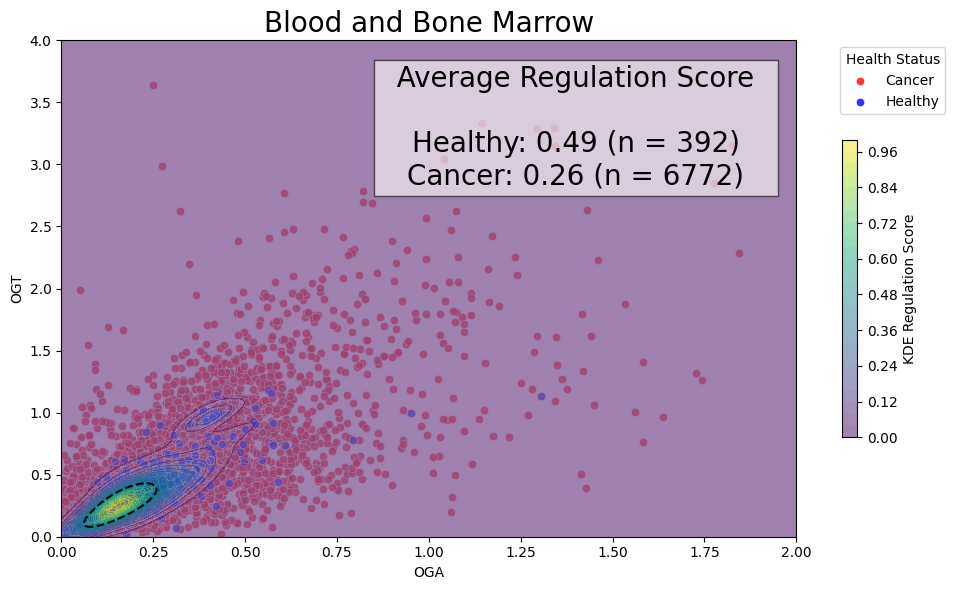

In [4]:
# --- Step 10: Visualize OGT vs. OGA with a heatmap ---
# This step generates a KDE-based heatmap to visualize the relationship between OGT and OGA expression levels.
# Additionally, it calculates and displays dysregulation scores for each sample.
# Individual healthmap from Figure 1

updated_clinical_manifest_duo_bmb, threshold_bmb = plot_ogt_vs_oga_with_heatmap(
    clinical_manifest_duo_bmb, 
    'cancer_type', 
    see_through=0.8, 
    remove_outliers=False, 
    plot_verification_points=False, 
    zoom_limits=[4, 2], 
    title="Blood and Bone Marrow"
)

# Lung

In [5]:
# --- Specify Cancer Type ---
# Define the cancer type to analyze, in this case, "Lung."
# Ensure all required data and directories exist under './data/TCGA_GeneExpression/Lung/'.
cancer_lng = "Lung"

# --- Define Target Genes ---
# Specify the genes of interest:
# - gene_name_lng: Single gene to focus on for initial processing.
# - gene_names_lng: List of genes for further analysis and visualization.
gene_name_lng = "OGT"
gene_names_lng = ["OGA", "OGT"]

# --- Step 1: Load the Clinical Manifest ---
# Load the clinical manifest for the specified cancer type.
# This file should have been saved in './data/TCGA_GeneExpression/Lung/' during the preprocessing steps.
clinical_manifest_lng = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_lng}/')

# --- Step 2: Clean the Clinical Manifest ---
# Remove irrelevant or empty columns from the clinical manifest.
# Update health-related columns for samples identified as healthy tissue.
clinical_manifest_lng = clean_dataframe(clinical_manifest_lng)

# --- Step 3: Verify File Integrity ---
# Compare filenames in the clinical manifest against those in the 'gene_expression' directory.
# This ensures all necessary gene expression files are available for processing.
print(analyze_filenames(clinical_manifest_lng, f'./data/TCGA_GeneExpression/{cancer_lng}/gene_expression'))

# --- Step 4: Load Gene Expression and Key Data ---
# Load previously saved gene expression data and its associated key file.
# These files should be located in './data/TCGA_GeneExpression/Lung/'.
gene_exps_lng, gene_key_lng = load_dataframes(
    f'./data/TCGA_GeneExpression/{cancer_lng}/gene_expression.csv', 
    f'./data/TCGA_GeneExpression/{cancer_lng}/gene_key.csv'
)

# --- Step 5: Normalize Gene Expression Data ---
# Normalize the gene expression data using Z-score normalization.
# This ensures data consistency across samples.
gene_exps_lng = normalize_gene_expressions(gene_exps_lng)

# --- Step 6: Add Gene Expressions to the Clinical Manifest ---
# Enrich the clinical manifest with multiple gene expressions (e.g., OGA and OGT).
clinical_manifest_duo_lng = add_multiple_gene_expressions_to_clinical(
    gene_exps_lng, clinical_manifest_lng, gene_key_lng, gene_names_lng
)

# --- Step 7: Classify Samples by Cancer Type ---
# Create a new column in the clinical manifest categorizing samples by cancer type.
clinical_manifest_duo_lng = create_cancer_type_column(clinical_manifest_duo_lng)

# --- Step 8: Combine Cancer Stages ---
# Simplify detailed cancer stages into broader categories and add as a new column.
clinical_manifest_duo_lng['cancer_stage'] = clinical_manifest_duo_lng['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)


Clinical manifest shape: (1996, 102)
Cleaned clinical manifest shape: (1996, 49)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:629: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:630: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


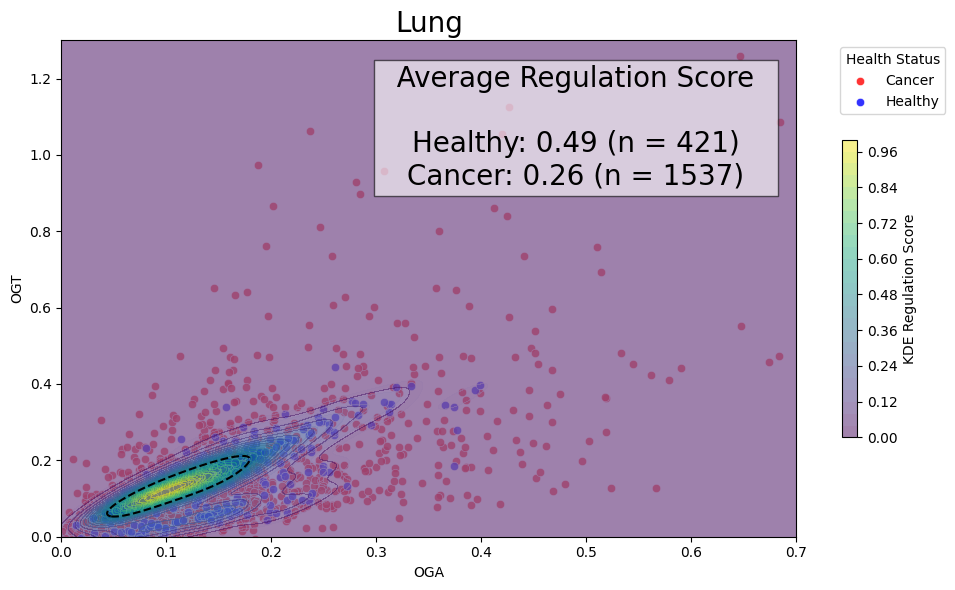

In [6]:
# --- Step 9: Visualize OGT vs. OGA with a Heatmap ---
# Generate a KDE-based heatmap visualizing OGT vs. OGA expression levels.
# Dysregulation scores are calculated and displayed for each sample.
# Individual healthmap from Figure 1

updated_clinical_manifest_duo_lng, threshold_lng = plot_ogt_vs_oga_with_heatmap(
    clinical_manifest_duo_lng, 
    'cancer_stage', 
    see_through=0.8, 
    remove_outliers=False, 
    plot_verification_points=False, 
    zoom_limits=[1.3, 0.7], 
    title=cancer_lng
)


# Kidney

In [7]:
# Same as for above
cancer_kid = "Kidney"
gene_name_kid = "OGT" 
gene_names_kid = ["OGA", "OGT"]

clinical_manifest_kid = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_kid}/')
clinical_manifest_kid = clean_dataframe(clinical_manifest_kid)

print(analyze_filenames(clinical_manifest_kid, f'./data/TCGA_GeneExpression/{cancer_kid}/gene_expression'))
gene_exps_kid, gene_key_kid = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_kid}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_kid}/gene_key.csv')
gene_exps_kid = normalize_gene_expressions(gene_exps_kid)

clinical_manifest_duo_kid = add_multiple_gene_expressions_to_clinical(gene_exps_kid, clinical_manifest_kid, gene_key_kid, gene_names_kid)
clinical_manifest_duo_kid = create_cancer_type_column(clinical_manifest_duo_kid)
clinical_manifest_duo_kid['cancer_stage'] = clinical_manifest_duo_kid['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)


Clinical manifest shape: (1842, 102)
Cleaned clinical manifest shape: (1842, 51)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:629: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:630: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


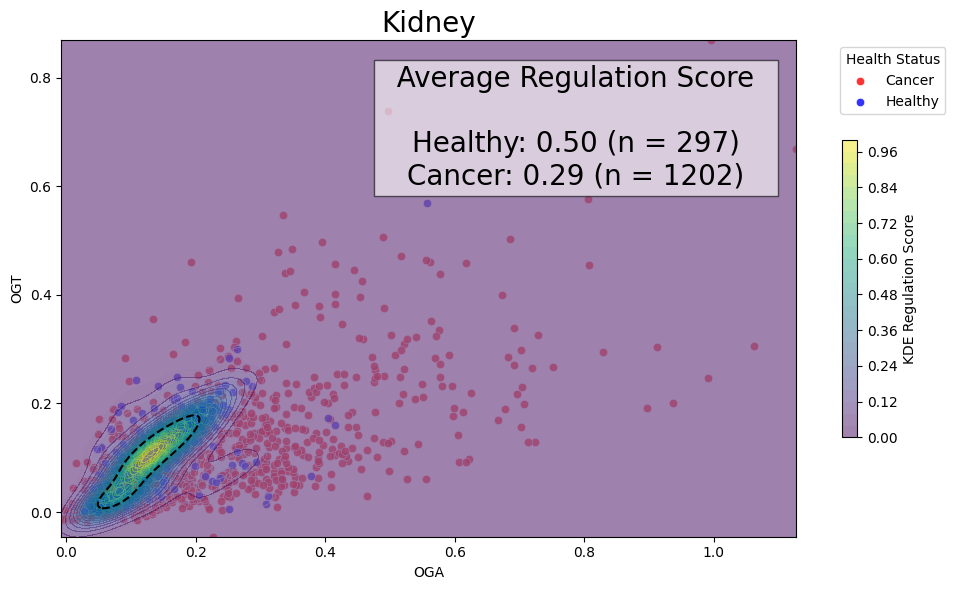

In [8]:
# Individual healthmap from Figure 1
updated_clinical_manifest_duo_kid, threshold_kid = plot_ogt_vs_oga_with_heatmap(clinical_manifest_duo_kid, 'cancer_stage', 0.8, 
                                                                 remove_outliers=False, plot_verification_points=False, title = cancer_kid)

# Breast

In [9]:
# Same as for above
cancer_brs = "Breast"
gene_name_brs = "OGT" 
gene_names_brs = ["OGA", "OGT"]

clinical_manifest_brs = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_brs}/')
clinical_manifest_brs = clean_dataframe(clinical_manifest_brs)

print(analyze_filenames(clinical_manifest_brs, f'./data/TCGA_GeneExpression/{cancer_brs}/gene_expression'))
gene_exps_brs, gene_key_brs = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_brs}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_brs}/gene_key.csv')
gene_exps_brs = normalize_gene_expressions(gene_exps_brs)

clinical_manifest_duo_brs = add_multiple_gene_expressions_to_clinical(gene_exps_brs, clinical_manifest_brs, gene_key_brs, gene_names_brs)
clinical_manifest_duo_brs = create_cancer_type_column(clinical_manifest_duo_brs)
clinical_manifest_duo_brs['cancer_stage'] = clinical_manifest_duo_brs['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)

Clinical manifest shape: (1594, 101)
Cleaned clinical manifest shape: (1594, 38)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:629: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:630: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


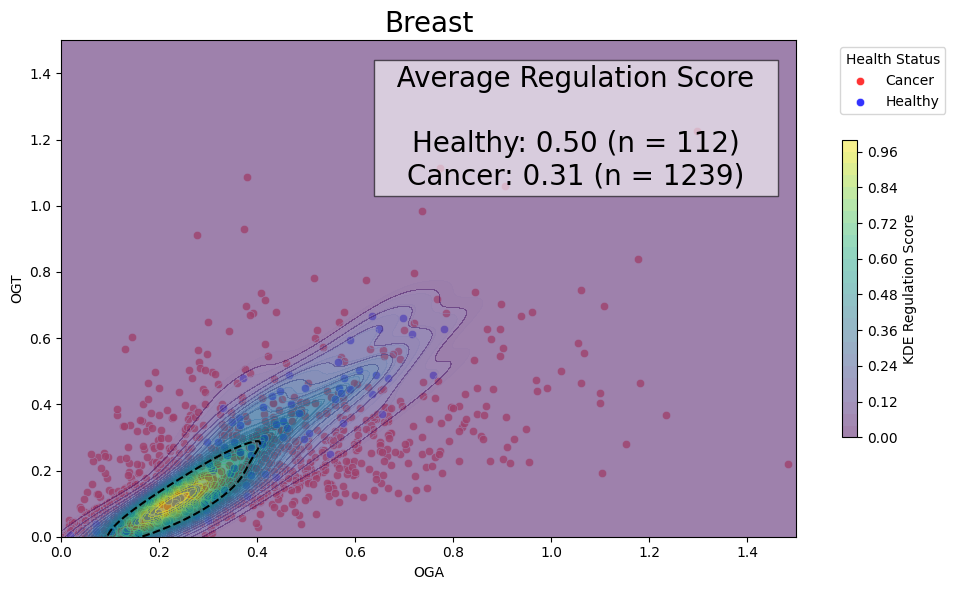

In [10]:
# Individual healthmap from Figure 1
updated_clinical_manifest_duo_brs, threshold_brs = plot_ogt_vs_oga_with_heatmap(clinical_manifest_duo_brs, 'cancer_stage', 0.8, 
                                                                 remove_outliers=False, plot_verification_points=False, 
                                                                 zoom_limits = [1.5, 1.5], title = cancer_brs)

# Thyroid

In [11]:
# Same as for above
cancer_thy = "Thyroid"
gene_name_thy = "OGT" 
gene_names_thy = ["OGA", "OGT"]

clinical_manifest_thy = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_thy}/')
clinical_manifest_thy = clean_dataframe(clinical_manifest_thy)

print(analyze_filenames(clinical_manifest_thy, f'./data/TCGA_GeneExpression/{cancer_thy}/gene_expression'))
gene_exps_thy, gene_key_thy = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_thy}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_thy}/gene_key.csv')
gene_exps_thy = normalize_gene_expressions(gene_exps_thy)

clinical_manifest_duo_thy = add_multiple_gene_expressions_to_clinical(gene_exps_thy, clinical_manifest_thy, gene_key_thy, gene_names_thy)
clinical_manifest_duo_thy = create_cancer_type_column(clinical_manifest_duo_thy)
clinical_manifest_duo_thy['cancer_stage'] = clinical_manifest_duo_thy['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)

Clinical manifest shape: (1402, 177)
Cleaned clinical manifest shape: (1402, 55)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:629: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:630: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


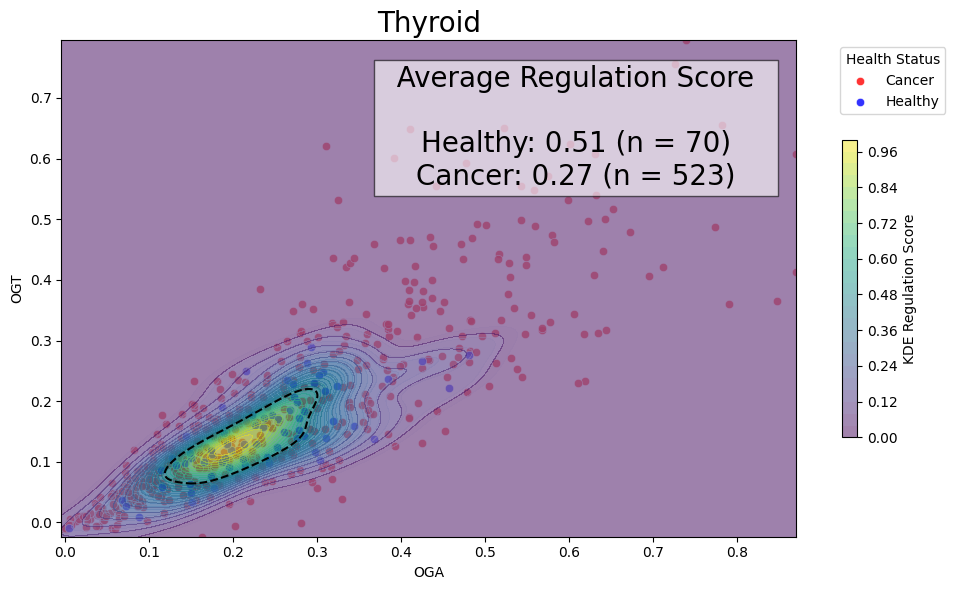

In [12]:
# Individual healthmap from Figure 1
updated_clinical_manifest_duo_thy, threshold_thy = plot_ogt_vs_oga_with_heatmap(clinical_manifest_duo_thy, 'cancer_stage', 0.8, 
                                                                 remove_outliers=False, plot_verification_points=False, title = cancer_thy)


# Uterine

In [13]:
# Same as for above
cancer_utr = "Uterus"
gene_name_utr = "OGT" 
gene_names_utr = ["OGA", "OGT"]

clinical_manifest_utr = load_clinical_manifest(f'./data/TCGA_GeneExpression/{cancer_utr}/')
clinical_manifest_utr = clean_dataframe(clinical_manifest_utr)

print(analyze_filenames(clinical_manifest_utr, f'./data/TCGA_GeneExpression/{cancer_utr}/gene_expression'))
gene_exps_utr, gene_key_utr = load_dataframes(f'./data/TCGA_GeneExpression/{cancer_utr}/gene_expression.csv', 
                                              f'./data/TCGA_GeneExpression/{cancer_utr}/gene_key.csv')
gene_exps_utr = normalize_gene_expressions(gene_exps_utr)

clinical_manifest_duo_utr = add_multiple_gene_expressions_to_clinical(gene_exps_utr, clinical_manifest_utr, gene_key_utr, gene_names_utr)
clinical_manifest_duo_utr = create_cancer_type_column(clinical_manifest_duo_utr)
clinical_manifest_duo_utr['cancer_stage'] = clinical_manifest_duo_utr['diagnosis_ajcc_pathologic_stage'].apply(combine_stages)

Clinical manifest shape: (1168, 102)
Cleaned clinical manifest shape: (1168, 44)
{'percent_unique_filenames_in_manifest': 100.0, 'percent_overlap_with_directory': 100.0, 'percent_non_overlap_with_directory': 0.0}


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:629: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if contour.collections and contour.collections[0].get_paths():
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:630: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  p = contour.collections[0].get_paths()[0]


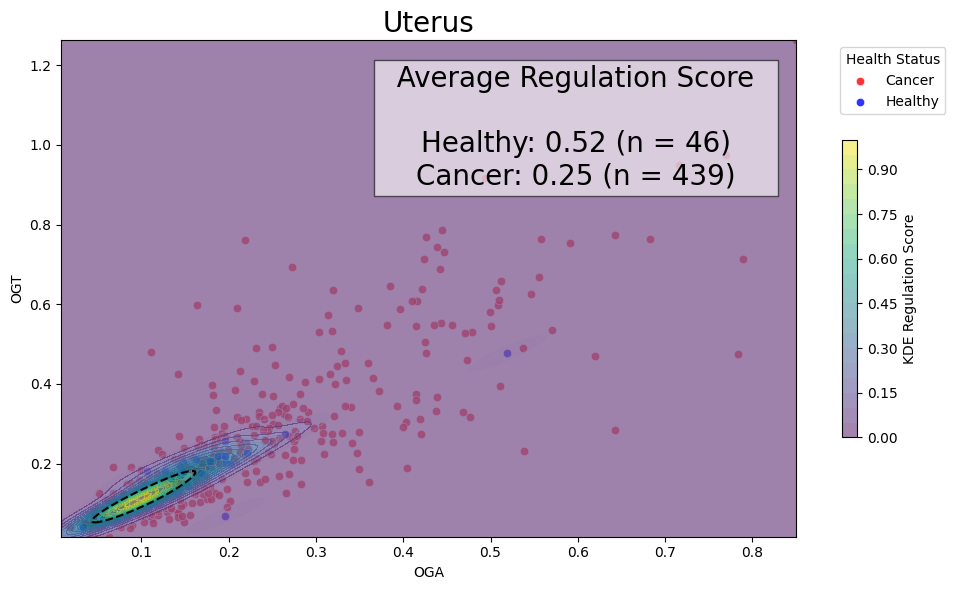

In [14]:
# Individual healthmap from Figure 1
updated_clinical_manifest_duo_utr, threshold_utr = plot_ogt_vs_oga_with_heatmap(clinical_manifest_duo_utr, 'cancer_stage', 0.8, 
                                                                 remove_outliers=False, plot_verification_points=False, 
                                                                 lvls = 20, title = cancer_utr)

In [15]:
updated_clinical_manifests_combined = [
    updated_clinical_manifest_duo_bmb,
    updated_clinical_manifest_duo_lng,
    updated_clinical_manifest_duo_kid,
    updated_clinical_manifest_duo_brs,
    updated_clinical_manifest_duo_thy,
    updated_clinical_manifest_duo_utr]

clinical_manifests_combined = [
    clinical_manifest_duo_bmb, 
    clinical_manifest_duo_lng, 
    clinical_manifest_duo_kid, 
    clinical_manifest_duo_brs, 
    clinical_manifest_duo_thy, 
    clinical_manifest_duo_utr]

thresholds = [threshold_bmb, 
              threshold_lng,
              threshold_kid, 
              threshold_brs, 
              threshold_thy,
              threshold_utr]

group_columns = [
    'cancer_type',
    'cancer_stage',
    'cancer_stage',
    'cancer_stage',
    'cancer_stage',
    'cancer_stage']

titles = [
    "Blood and Bone Marrow",
    "Lung",
    "Kidney",
    "Breast",
    "Thyroid",
    "Uterine"]

lvls_list = [30, 30, 30, 30, 30, 20]  # Set individual contour levels for each dataset
zoom_limits = [[4, 2], [1.3, 0.7], None, [1.5, 1.5], None, None]  # Specific zoom limits for each plot

for df, name in zip(updated_clinical_manifests_combined, ['Blood and Bone Marrow', 'Lung', 'Kidney', 'Breast', 'Thyroid', 'Uterine']):
    df.name = name

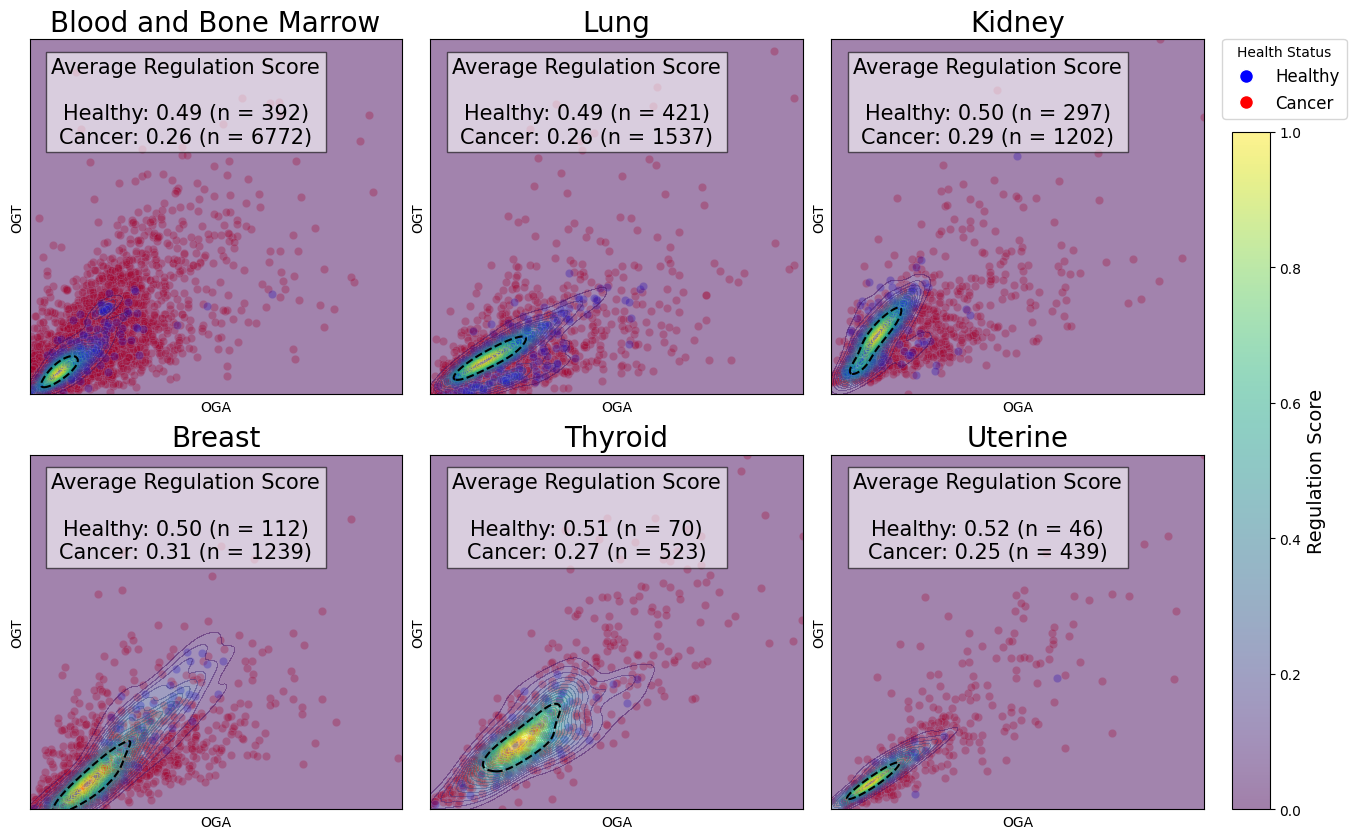

In [16]:
# Nice plotting (combined individual heat plots)
# FIGURE 1
plot_ogt_vs_oga_with_heatmap_grid_compact(clinical_manifests_combined, group_columns, titles, thresholds=thresholds, 
                                          lvls_list=lvls_list, see_through=0.3, zoom_limits=zoom_limits)

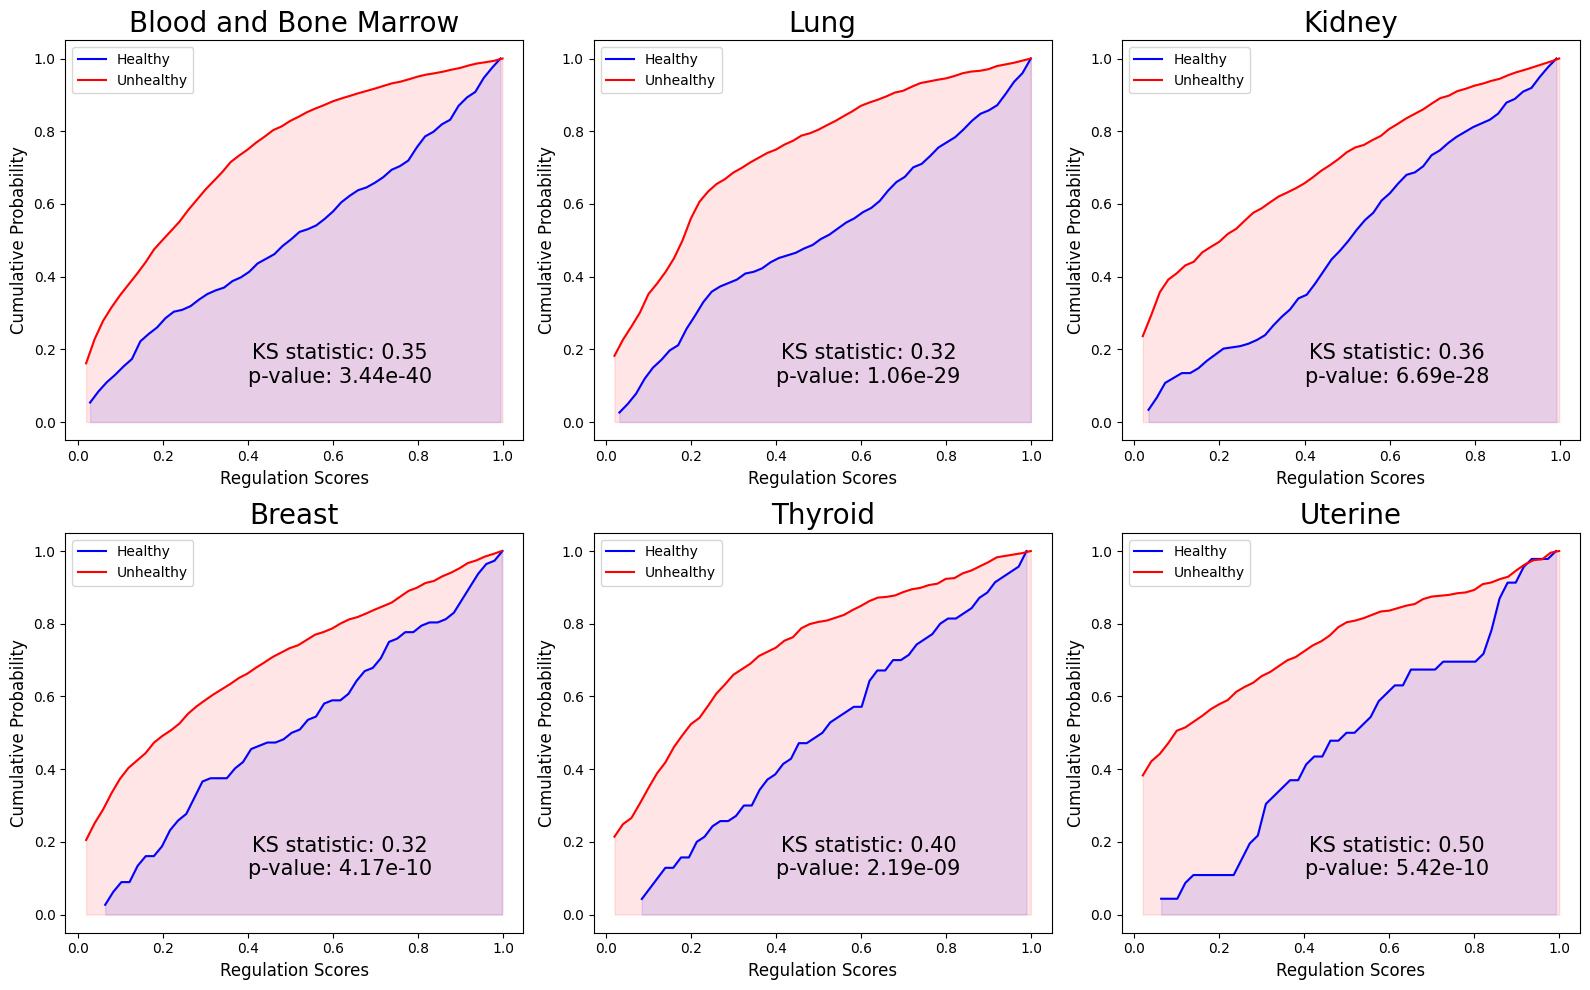

In [17]:
# Perform statistical comparison of dysregulation distributions across cancer types
# FIGURE 2
results_df = compare_dysregulation_distribution(updated_clinical_manifests_combined, group_columns)


/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:855: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:855: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:855: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/hm/zfbz8bvd2c5_x7332044tj9c2lxsgx/T/ipykernel_34957/1588726313.py:855: FutureWarning: 

Passing `palette` without assigning `hue` is deprecat

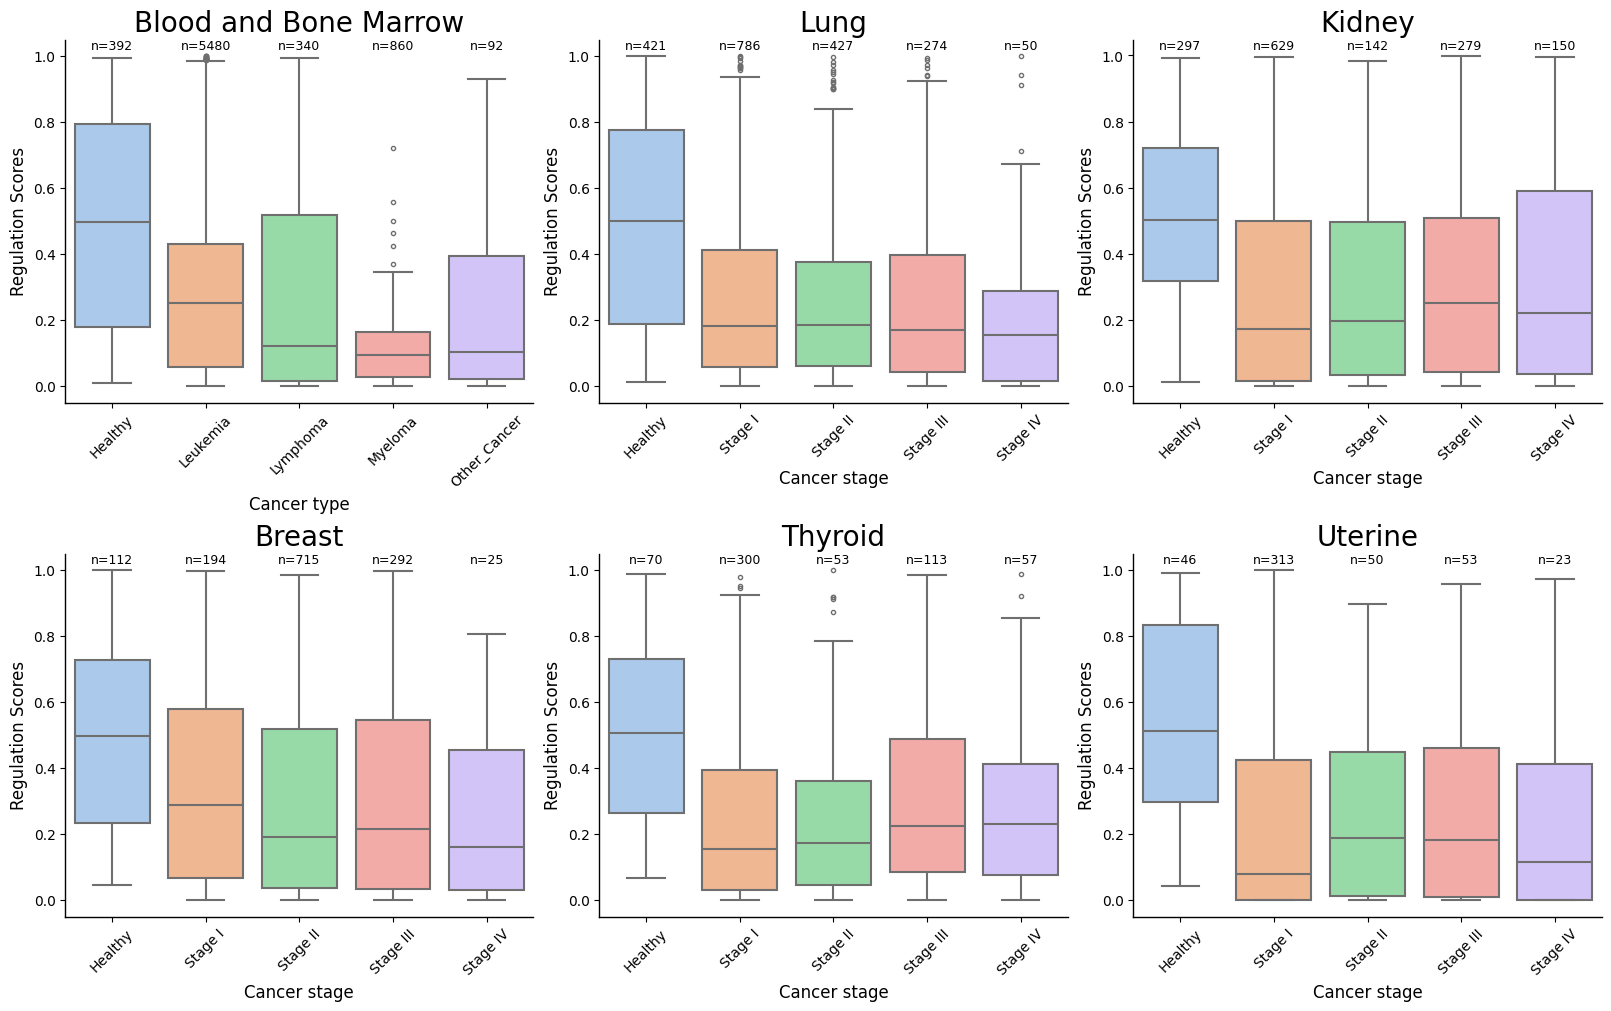

In [18]:
# Show regulation scores by type/stage
# SUPPLEMENTARY FIGURE 3
plot_regulation_scores_grid(updated_clinical_manifests_combined,group_columns,titles, figsize=(16,10))


In [ ]:
# save results
save_updated_clinical_manifests_combined(updated_clinical_manifests_combined, './data/regulation_score_results.pkl')